## Benchmark for measuring performance of engineered features and models
Add features created from previous and next records in original order

In [22]:
import os
if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time
import gc

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [3]:
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    new_mcc = 0
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc
    
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc

In [4]:
def cross_val_predict_rskf(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False, early_stopping=10):
    '''
    Repeated stratified KFold CV, returns predictions for 
    each repeat and average score.
    n_repeats: repetitions of CV
    to disable erlay stopping, set early_stopping to None
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []
    
    rskf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_splits, 
                                   random_state=0)
    np.random.seed(random_state)
    for n, (train_index, test_index) in enumerate(rskf.split(x_train, y_train)):
        print('Round {}'.format(n))
        start_time = time.time()
        x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.random_state = np.random.randint(10000000)
        
        if early_stopping is not None:
            clf.fit(x_train_tmp, y_train_tmp, 
                    eval_set=[(x_test_tmp, y_test_tmp)], 
                    eval_metric=mcc_eval, early_stopping_rounds=early_stopping,
                    verbose=verbose)
            scores.append(-clf.best_score)
            n_trees.append(clf.best_ntree_limit)
        else:
            clf.fit(x_train_tmp, y_train_tmp)
            scores.append(eval_mcc(y_test_tmp.values, clf.predict_proba(x_test_tmp)[:, 1]))
            n_trees.append(clf.n_estimators)
        
        clfs.append(clf)
        running_time.append(time.time()-start_time)
        print('Split {}, score = {:.3f}, best_ntree_limit = {}, total time = {:.3f} min'.format(n, scores[n], 
            n_trees[n], sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [5]:
def cross_val_predict_skf_rm(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False, early_stopping=10):
    '''
    Stratified KFold CV with repeated models
    to disable erlay stopping, set early_stopping to None
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []

    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    np.random.seed(random_state)

    for m in range(n_repeats):
        print('Repeat {}'.format(m))
        for n, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
            start_time = time.time()
            x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
            y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

            clf.random_state = np.random.randint(10000000)
            # print(clf.random_state)

            if early_stopping is not None:
                clf.fit(x_train_tmp, y_train_tmp, 
                        eval_set=[(x_test_tmp, y_test_tmp)], 
                        eval_metric=mcc_eval, early_stopping_rounds=early_stopping,
                        verbose=verbose)
                scores.append(-clf.best_score)
                n_trees.append(clf.best_ntree_limit)
            else:
                clf.fit(x_train_tmp, y_train_tmp)
                scores.append(eval_mcc(y_test_tmp.values, clf.predict_proba(x_test_tmp)[:, 1]))
                n_trees.append(clf.n_estimators)
            
            clfs.append(clf)
            running_time.append(time.time() - start_time)
            print('Split {}, score = {:.3f}, n_best_trees = {}, total time = {:.3f} min'.format(n, 
                scores[m*n_repeats+n], n_trees[m*n_repeats+n], sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [24]:
def cross_val_predict_skf_rm_xgb(params, x_train, y_train, num_boost_round=3, n_splits=3, 
                           n_repeats=2, random_state=3795264, verbose_eval=False):
    '''
    Stratified KFold CV with repeated models
    Early stopping is totally disabled
    Uses xgb.cv API
    verbose_eval is the same as in xgb.train
    '''
    cv_results = {}
    clfs = {}
    running_time = {}
    
    np.random.seed(random_state)
    skf = StratifiedKFold(n_splits=n_splits, random_state=np.random.randint(10**6), shuffle=True)
    
    for m in range(n_repeats):
        for n, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
            
            start_time = time.time()
            
            # Construct DMatrix
            dtrain = xgb.DMatrix(x_train.iloc[train_index], label=y_train.iloc[train_index])
            dtest = xgb.DMatrix(x_train.iloc[test_index], label=y_train.iloc[test_index])
            
            # Placeholder for evals_result
            cv_results[m, n] = {}
            params['seed'] = np.random.randint(10**6)
            clfs[m, n] = xgb.train(params, dtrain, num_boost_round=num_boost_round,
                                   evals=[(dtrain, 'train'), (dtest, 'test')],
                                  feval=mcc_eval, maximize=True, early_stopping_rounds=None, 
                                  evals_result=cv_results[m, n], verbose_eval=verbose_eval)
        
            running_time[m, n] = time.time() - start_time
            
            print('Repeat {}, split {}, test MCC = {:.3f}, running time = {:.3f} min'.format(m, n, 
                cv_results[m, n]['test']['MCC'][-1], running_time[m, n]/60))
        
    # Post-process cv_results
    cv_results_final = {}
    for m in range(n_repeats):
        for n in range(n_splits):
            cv_results_final['train', m, n] = cv_results[m, n]['train']['MCC']
            cv_results_final['test', m, n] = cv_results[m, n]['test']['MCC']
    
    df = pd.DataFrame.from_dict(cv_results_final)
    df.index.name = 'iteration'
    df.columns.names = ['dataset', 'repeat', 'split']

    print('Score mean = {:.3f}, std = {:.3f}'.format(df['test'].iloc[-1].mean(), df['test'].iloc[-1].std()))
    
    return df, clfs, running_time

### Load train and test data

In [7]:
# important numeric features are imported
important_features = pd.read_csv('../benchmark_1/important_numeric_features.csv', index_col=0, header=None)
important_features = list(important_features.values.ravel())
important_features.extend(['Id', 'Response'])

In [8]:
x_train_numeric = pd.read_csv('../../data/train_numeric.csv.zip', index_col=0, usecols=important_features, dtype=np.float32)

y_train = x_train_numeric.Response
x_train_numeric.drop(['Response'], axis=1, inplace=True)

In [9]:
date_train = pd.read_csv('../benchmark_2/train_station_flow.csv.gz', index_col=0, header=None)

In [10]:
x_train = x_train_numeric.join(date_train)

columns = list(x_train.columns)
columns[-1] = 'station_flow'
x_train.columns = columns

In [11]:
x_test_numeric = pd.read_csv('../../data/test_numeric.csv.zip', index_col=0, usecols=important_features[:-1], dtype=np.float32)

date_test = pd.read_csv('../benchmark_2/test_station_flow.csv.gz', index_col=0, header=None)

x_test = x_test_numeric.join(date_test)
x_test.columns = columns

In [12]:
x_train.index = x_train.index.astype(np.int64)
x_test.index = x_test.index.astype(np.int64)

In [13]:
del x_train_numeric, x_test_numeric
gc.collect()

516

### Load benchmark_3 features

In [14]:
start_chunk = pd.read_csv('../benchmark_3/start_chunk.csv.gz', index_col=0)

start_chunk_train = start_chunk.loc[start_chunk.Response!=-1].drop(['Response'], axis=1)
start_chunk_test = start_chunk.loc[start_chunk.Response==-1].drop(['Response'], axis=1)

In [15]:
x_train = x_train.join(start_chunk_train, on='Id')
x_test = x_test.join(start_chunk_test, on='Id')

gc.collect()

35

### Load benchmark_4 features

In [16]:
n = pd.read_csv('../benchmark_4/benchmark_4_neighbors.csv.gz', index_col=0)

neighbor_train = n.loc[n.Response!=-1]
neighbor_train.drop(['Response'], axis=1, inplace=True)

neighbor_test = n.loc[n.Response==-1]
neighbor_test.drop(['Response'], axis=1, inplace=True)

print(neighbor_test.shape, neighbor_train.shape)

x_train = x_train.join(neighbor_train, on='Id')
x_test = x_test.join(neighbor_test, on='Id')

gc.collect()

(1183748, 14) (1183747, 14)


28

### Add neighbor numeric features
The important numeric features selected from previous and next records

In [17]:
# Date + station flow data will be added to x
x = pd.concat([x_train, x_test], keys=['train', 'test'])
x.sort_index(axis=0, level='Id', inplace=True)

# Add the neighbor records
x = x.join(x.iloc[:, :150].shift(), rsuffix='_previous')
x = x.join(x.iloc[:, :150].shift(-1), rsuffix='_next')

In [18]:
x_train = x.loc['train']
x_test = x.loc['test']

In [19]:
del x
gc.collect()

63

In [20]:
# u = x.iloc[:, :150].shift()
# x = x.join(u, rsuffix='_previous')

#pd.Series(x.columns).to_csv('x_colname.csv')

### CV score based on stratified KFold with repeated models

In [45]:
# CV
# specify parameters 
# 'booster':'gbtree'
#params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthred':20,
#         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'gbtree', 'alpha':0,
#         'base_score':0.0058, 'nthread':20, 'colsample_bytree':0.6}

# 'booster':'dart'
params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthred':20,
         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'dart', 'alpha':0,
         'base_score':0.0058, 'nthread':20, 'colsample_bytree':0.6}

cv_results, clfs, running_time = cross_val_predict_skf_rm_xgb(params, x_train, y_train, 
                                                              num_boost_round=80, n_splits=5, 
                                                              n_repeats=3, random_state=5876967, 
                                                              verbose_eval=False)

results = {'clfs': clfs, 'cv_results': cv_results, 'running_time': running_time}
save_pickle(results, 'results_benchmark_6_cv_dart.pickle')

KeyboardInterrupt: 

In [37]:
cv_train_mean = -cv_results['train'].mean(axis=1)
cv_train_std = cv_results['train'].std(axis=1)
cv_test_mean = -cv_results['test'].mean(axis=1)
cv_test_std = cv_results['test'].std(axis=1)

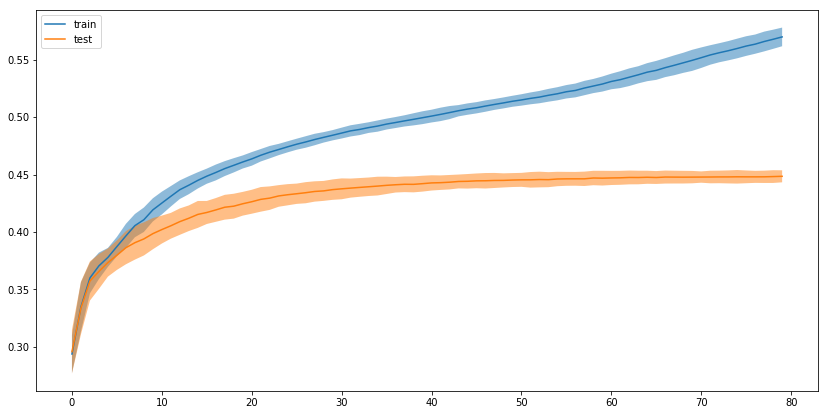

In [43]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(cv_train_mean)), cv_train_mean)
plt.fill_between(np.arange(len(cv_train_mean)), cv_train_mean-cv_train_std, cv_train_mean+cv_train_std, alpha=0.5)
plt.plot(np.arange(len(cv_train_mean)), cv_test_mean)
plt.fill_between(np.arange(len(cv_test_mean)), cv_test_mean-cv_test_std, cv_test_mean+cv_test_std, alpha=0.5)
plt.legend(['train', 'test'])

[0]	train-error:0.005811	train-MCC:-0.257135
[1]	train-error:0.005811	train-MCC:-0.320215
[2]	train-error:0.005811	train-MCC:-0.327153
[3]	train-error:0.005811	train-MCC:-0.367129
[4]	train-error:0.005811	train-MCC:-0.385755
[5]	train-error:0.005811	train-MCC:-0.400644
[6]	train-error:0.005811	train-MCC:-0.410951
[7]	train-error:0.005811	train-MCC:-0.420161
[8]	train-error:0.005811	train-MCC:-0.422455
[9]	train-error:0.005811	train-MCC:-0.431106
[10]	train-error:0.005811	train-MCC:-0.432288
[11]	train-error:0.00581	train-MCC:-0.433875
[12]	train-error:0.00581	train-MCC:-0.436738
[13]	train-error:0.00581	train-MCC:-0.44055
[14]	train-error:0.005809	train-MCC:-0.443833
[15]	train-error:0.005807	train-MCC:-0.445532
[16]	train-error:0.005807	train-MCC:-0.44881
[17]	train-error:0.005805	train-MCC:-0.451052
[18]	train-error:0.005769	train-MCC:-0.453217
[19]	train-error:0.005748	train-MCC:-0.456517
[20]	train-error:0.005689	train-MCC:-0.460238
[21]	train-error:0.005603	train-MCC:-0.462709
[22

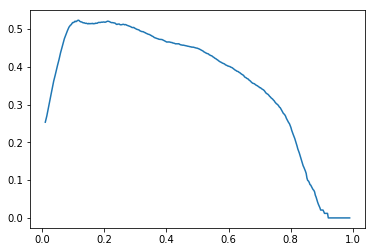

In [26]:
# Train the model
dtrain = xgb.DMatrix(x_train, label=y_train)
params['seed'] = 28537894
clf = xgb.train(params, dtrain, num_boost_round=60,
               feval=mcc_eval, evals=[(dtrain, 'train')])

y_train_pred = clf.predict(dtrain)

# Find best threshold 
thresholds = np.linspace(0.01, 0.99, 400)
mcc = np.array([matthews_corrcoef(y_train, y_train_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]

print('Optimal MCC = {:.3f}'.format(mcc.max()))
print('Optimal threshold = {:.3f}'.format(best_threshold))

### Predict on test data

In [27]:
dtest = xgb.DMatrix(x_test)
y_test_pred = clf.predict(dtest)
y_test_pred_int = (y_test_pred>best_threshold).astype(int)

sub = pd.read_csv("../../data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("15-benchmark_6_submission_nestimators_60_2.csv.gz", compression="gzip")

`n_estimators=50`: Private MCC = 0.45102, public MCC = 0.43507

`n_estimators=40`: CV MCC mean = 0.440, std = 0.008


`n_estimators=75`: Private MCC = 0.41463, public MCC = 0.40368

`n_estimators=60`: Private MCC = 0.45539, public MCC = 0.44090

`n_estimators=60`: CV MCC mean = 0.444, std = 0.006

